In [9]:
from get_data import get_commits, get_tags
import pandas as pd
import os

In [10]:
def process_generator(func, year):
    try:
        token = os.environ["PRIVATE_TOKEN"]
    except KeyError:
        token = input("Private Token: ")
    gen = func(year, token)
    data = []
    for i in gen:
        data.append(i)
    return data

In [11]:
commits = process_generator(get_commits, 2021)
tags = process_generator(get_tags, 2021)

In [12]:
df = pd.json_normalize(commits)
df_tags = pd.json_normalize(tags)

In [13]:
df["created_at"] = pd.to_datetime(df['created_at'], utc=True)
df_tags["commit.created_at"] = pd.to_datetime(df_tags["commit.created_at"], utc=True)

In [14]:
df_tags = df_tags[df_tags.name.str.contains("testing").apply(lambda x: not x)]

In [15]:
new_df = df.resample("W", on="created_at").count()["id"].to_frame()

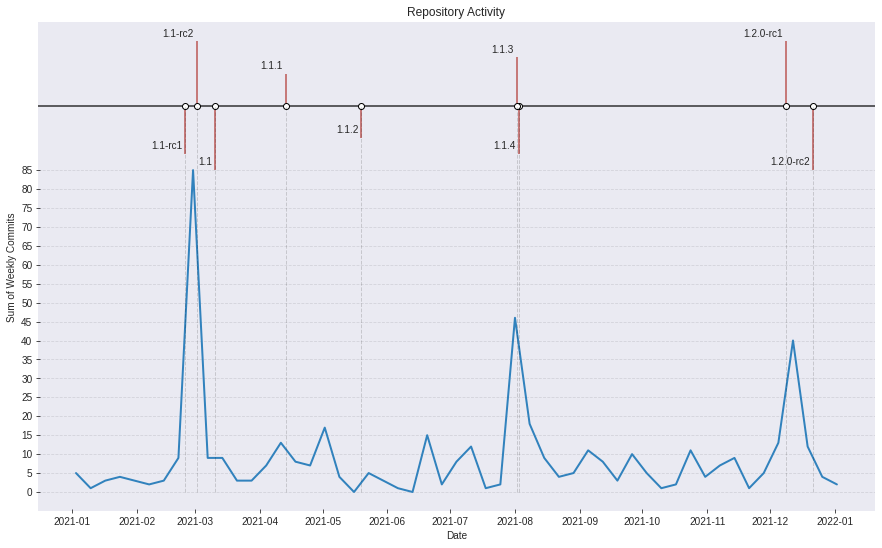

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

plt.style.use('seaborn-dark')

fig, ax = plt.subplots(figsize=(15, 9))

length = len(df_tags)
color = plt.cm.twilight(np.linspace(0, 1, length))

ax.plot(new_df, linewidth=2, color="#3182bd")

dates = df_tags["commit.created_at"]
names = df_tags["name"]

top_offset = 0.2 * max(new_df.id)
timeline_baseline_y = max(new_df.id) + top_offset

levels = np.tile([timeline_baseline_y for i in dates] + np.resize(
    [-top_offset, top_offset, -0.15 * max(new_df.id), 0.15 * max(new_df.id), -0.1 * max(new_df.id),
     0.1 * max(new_df.id)], len(dates)),
                 int(np.ceil(len(dates) / 6)))[:len(dates)]

# v-lines from timeline
ax.vlines(dates, timeline_baseline_y, levels, linestyle='-', color='#A40C04', linewidth=2,
          alpha=0.5)
# Baseline and markers on it.
ax.axhline(y=timeline_baseline_y, color="black", alpha=0.8)
ax.plot(dates, [timeline_baseline_y for i in dates], "o",
        color="k", markerfacecolor="w")

# annotate lines
for d, l, r in zip(dates, levels, names):
    ax.annotate(r, xy=(d, l),
                xytext=(-3, np.sign(l) * 3), textcoords="offset points",
                horizontalalignment="right",
                verticalalignment="bottom" if l > 0 else "top")

x1, x2, y1, y2 = plt.axis()
# add space on y-ax for longest offset upwards
plt.axis((x1, x2, y1, y2 + top_offset))
# add dotted v-lines for all dates
ax.vlines(dates, 0, [timeline_baseline_y for i in dates], linestyle='--', color='black', linewidth=1, alpha=0.15)
ax.set_title("Repository Activity")
ax.set_ylabel('Sum of Weekly Commits')
ax.set_xlabel('Date')
ax.grid(axis='y', linestyle='dashed', color='black', alpha=0.10)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(direction="inout", length=4)

plt.yticks(np.arange(0, max(new_df.id) + 5, 5))
plt.savefig('images/reposority_activity.png')

In [17]:
df_test = df["author_name"].value_counts().value_counts().sort_values(
    ascending=False).to_frame().reset_index().sort_values("index")
df_test.index = df_test["index"]
df_test = df_test["index"] * df_test["author_name"]
df_test = df_test.to_frame()
df_test.columns = ["data"]

In [18]:
larger = df_test["data"][df_test.index >= 23].sum()
smaller = df_test["data"][df_test.index < 23].sum()

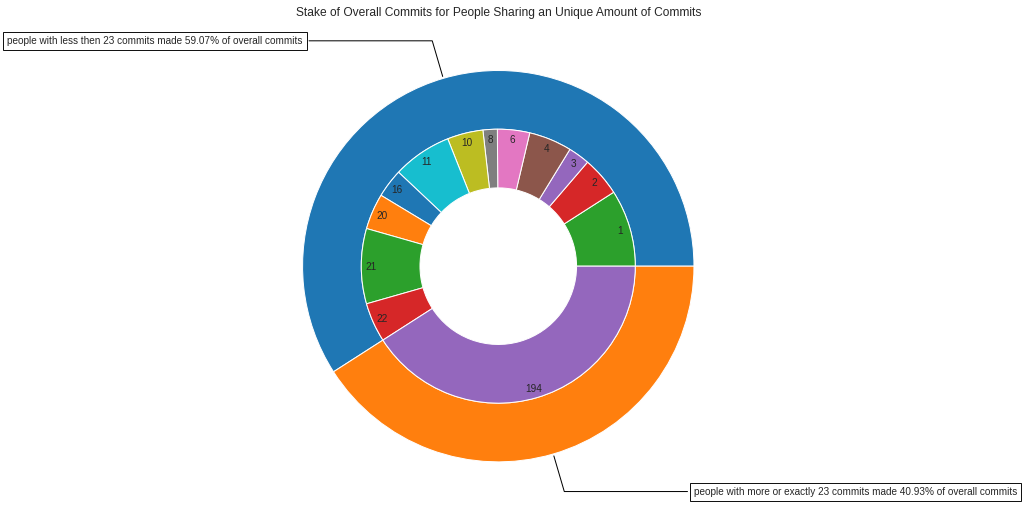

In [19]:
fig, ax = plt.subplots(figsize=(15, 9), subplot_kw=dict(aspect="equal"))
ax.axis('equal')
width = 0.3

w, l = plt.pie([smaller, larger], wedgeprops=dict(width=0.5))
plt.setp(w, width=width, edgecolor='white', radius=1)



w2, l = plt.pie(df_test["data"], wedgeprops=dict(width=0.5), labels=df_test.index, labeldistance=0.65)

for t in l:
    t.set_horizontalalignment('center')

plt.setp(w2, width=0.6 - width, edgecolor='white',radius=1-width)



bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.92)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(w):
    percentage = [smaller, larger][i] / df_test.data.sum()
    percentage = str(round(percentage * 100, 2)) + "%"
    if df_test.index[i] == 1:
        text = f'people with less then 23 commits made {percentage} of overall commits'
    else:
        text = f'people with more or exactly 23 commits made {percentage} of overall commits'
    ang = (p.theta2 - p.theta1) / 2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(text, xy=(x, y), xytext=(1 * np.sign(x), 1.2 * y),
                horizontalalignment=horizontalalignment, **kw)
ax.set_title("Stake of Overall Commits for People Sharing an Unique Amount of Commits")
plt.savefig('images/stake_of_commits.png')